**Models**

In this paper, we have used three different machine learning algorithms to classify the target variable. For that purpose we have splitted the target into two categories that define whether the human wearing the insole is moving or not. The categories of sitting, standing and no activity were combined to represent no movement and the rest to represent some movement, e.g. walking, mixed walking. 

In [1]:
import sys; sys.path.insert(0, 'c:/users/ofir6/desktop/projects/HAR_new/')
from src.config import data_raw_path, save_model_dir, save_clean_data
from src.utils import pre_process, corr_matrix, create_features, predict_logit, pedict_logit_best, predict_dt, predict_RF, plot_aoc_auc
from src.utils import create_catboost_features, catboost_model, create_catboost_few_features
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
df = pd.read_csv(data_raw_path, index_col=0)
df.head(2)

,s1_mean,s2_mean,s3_mean,x_mean,y_mean,z_mean,s1_variation,s2_variation,s3_variation,x_variation,...,x_peak_prom_stand,y_peak_prom_sit,y_peak_prom_stand,x_y_corr,z_y_corr,x_z_corr,id,Name,Kg,Target
0,91.0025,88.8400,127.6475,178.6475,-58.6525,-1331.735,1.408888,0.891958,1.271568,5.805104,...,16.700311,11.316770,11.316770,-0.810465,0.260219,-0.356973,user_1,a,89.2,Walking
1,90.1400,81.1725,140.3850,148.8150,-20.3150,-1343.855,1.308428,0.836050,1.250638,6.742590,...,17.788430,11.424793,11.424793,-0.752337,0.284737,-0.337889,user_2,a,89.2,Walking


In [3]:
df = pre_process(df)
#Find indexes of feature columns with correlation greater than 0.75 and drop these features
df = corr_matrix(df)

In [4]:
#df.to_csv(save_clean_data / 'cleaned_df.csv', index=False)

In [5]:
#As the data set suffered from high-dimensionality it was divided into training and testing sets for validating the model accuracy on test data as well. 
#The splitting was done manually to avoid random splits that would include the same person both in train and test.
X, Y, x_train, x_test, y_train, y_test = create_features(df)

**Logistic Regression**

We have used multinomial logistic regression algorithms that might be useful not only for prediction but also for identifying important features and eliminating unimportant ones. This approach may remarkably reduce the dimension and maintain the most discriminative information

In [6]:
predict_logit(x_train, x_test, y_train, y_test)

Optimization terminated successfully.
         Current function value: 0.036329
         Iterations 14
Accuracy_train: 0.98
Sensitivity_train: 0.97
Specificity_train: 0.99

Accuracy_test: 0.95
Sensitivity_test: 0.92
Specificity_test: 0.96

Train:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1729
           1       0.96      0.97      0.96       462

    accuracy                           0.98      2191
   macro avg       0.97      0.98      0.98      2191
weighted avg       0.99      0.98      0.98      2191

Test:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       179
           1       0.81      0.92      0.86        38

    accuracy                           0.95       217
   macro avg       0.90      0.94      0.92       217
weighted avg       0.95      0.95      0.95       217


              Accuracy   ROC_AUC    Recall
Training set  0.984938  0.998736  0.971861
Testin

Going beyond the accuracy of the model we see that for the test data Logistic Regression had a precision of 0.81. for positive cases (not moving). Precision is defined as the number of true positives divided by the number of true positives plus the number of false positives. False positives are cases the model incorrectly labels as positive that are actually negative, or in our example, individuals the model classifies as not moving(1) while they are moving (0). While recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant

Preliminary logistic regression showed a big number of insignificant features. Using backward
elimination technique and closely following the predictive power of the model we removed some of the
variables. We have optimized all three models through hyperparameter optimization and finding the best
parameters for all three models.

**Logit with best parameters**

In [6]:
pedict_logit_best(X, Y, x_train, x_test, y_train, y_test)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
ROC_AUC Train for tuned Logit: 0.96
ROC_AUC Test for tuned Logit: 0.98
Mean 5-fold ROC AUC score for Tuned Logit 0.96


**Decision Tree**

In [7]:
predict_dt(X, Y, x_train, x_test, y_train, y_test)

ROC_AUC Train for tuned DT: 0.99
ROC_AUC Test for tuned DT: 0.96
Mean 5-fold ROC AUC score for Tuned DT 0.97


**Random Forest**

In [4]:
model_RF = predict_RF(X, Y, x_train, x_test, y_train, y_test)

ROC_AUC Train for tuned RF: 1.0
ROC_AUC Test for tuned RF: 0.99
Mean 5-fold ROC AUC score for Tuned RF 0.98
Random Forest Train:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1729
           1       0.93      0.98      0.96       462

    accuracy                           0.98      2191
   macro avg       0.96      0.98      0.97      2191
weighted avg       0.98      0.98      0.98      2191

Random Forest Test:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       179
           1       0.86      0.95      0.90        38

    accuracy                           0.96       217
   macro avg       0.92      0.96      0.94       217
weighted avg       0.97      0.96      0.96       217



In [8]:
#save the best model - Random Forest
pickle.dump(model_RF, open(save_model_dir / 'model_RF.pkl', 'wb'))

In [4]:
#load the best model - Random Forest
model_RF = pickle.load(open(save_model_dir / 'model_RF.pkl', 'rb'))

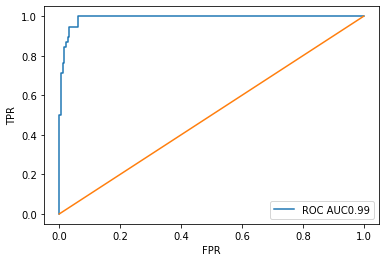

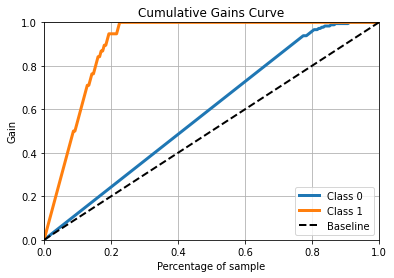

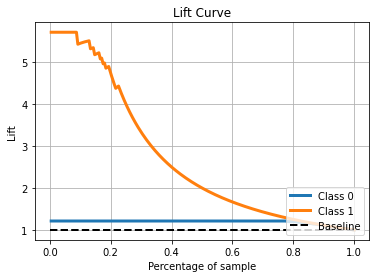

In [5]:
plot_aoc_auc(x_test, y_test, model_RF)

**Catboost MultiClass Classifier With All Targets**

In [4]:
X, Y, x_train, x_test, y_train, y_test = create_catboost_features(df)

In [6]:
cat_model = catboost_model(x_train, y_train, x_test, y_test)
pickle.dump(cat_model, open(save_model_dir / 'cat_model.pkl', 'wb'))

Learning rate set to 0.082356
0:	learn: 2.0867347	total: 126ms	remaining: 2m 5s
1:	learn: 1.9140786	total: 251ms	remaining: 2m 5s
2:	learn: 1.7933819	total: 376ms	remaining: 2m 4s
3:	learn: 1.6935922	total: 505ms	remaining: 2m 5s
4:	learn: 1.5889944	total: 632ms	remaining: 2m 5s
5:	learn: 1.5085681	total: 763ms	remaining: 2m 6s
6:	learn: 1.4370044	total: 886ms	remaining: 2m 5s
7:	learn: 1.3616641	total: 1.01s	remaining: 2m 5s
8:	learn: 1.3068833	total: 1.13s	remaining: 2m 4s
9:	learn: 1.2558176	total: 1.27s	remaining: 2m 5s
10:	learn: 1.2037221	total: 1.4s	remaining: 2m 6s
11:	learn: 1.1624847	total: 1.54s	remaining: 2m 7s
12:	learn: 1.1236276	total: 1.68s	remaining: 2m 7s
13:	learn: 1.0814972	total: 1.82s	remaining: 2m 8s
14:	learn: 1.0437287	total: 1.95s	remaining: 2m 7s
15:	learn: 1.0084926	total: 2.06s	remaining: 2m 6s
16:	learn: 0.9777528	total: 2.19s	remaining: 2m 6s
17:	learn: 0.9551981	total: 2.33s	remaining: 2m 7s
18:	learn: 0.9308567	total: 2.47s	remaining: 2m 7s
19:	learn: 0

**Catboost MultiClass Classifier with Fewer Targets**

In [7]:
X, Y, x_train, x_test, y_train, y_test = create_catboost_few_features(df)

In [8]:
cat_model_few = catboost_model(x_train, y_train, x_test, y_test)

Learning rate set to 0.082356
0:	learn: 1.4300976	total: 204ms	remaining: 3m 23s
1:	learn: 1.2975605	total: 252ms	remaining: 2m 5s
2:	learn: 1.1966842	total: 299ms	remaining: 1m 39s
3:	learn: 1.1080932	total: 344ms	remaining: 1m 25s
4:	learn: 1.0372487	total: 389ms	remaining: 1m 17s
5:	learn: 0.9763907	total: 443ms	remaining: 1m 13s
6:	learn: 0.9143430	total: 511ms	remaining: 1m 12s
7:	learn: 0.8621969	total: 554ms	remaining: 1m 8s
8:	learn: 0.8175421	total: 600ms	remaining: 1m 6s
9:	learn: 0.7732514	total: 644ms	remaining: 1m 3s
10:	learn: 0.7345698	total: 694ms	remaining: 1m 2s
11:	learn: 0.7009531	total: 751ms	remaining: 1m 1s
12:	learn: 0.6754313	total: 819ms	remaining: 1m 2s
13:	learn: 0.6435120	total: 866ms	remaining: 1m
14:	learn: 0.6150112	total: 914ms	remaining: 1m
15:	learn: 0.5910873	total: 965ms	remaining: 59.3s
16:	learn: 0.5717387	total: 1.02s	remaining: 58.9s
17:	learn: 0.5520383	total: 1.07s	remaining: 58.7s
18:	learn: 0.5384573	total: 1.17s	remaining: 1m
19:	learn: 0.5